In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
os.environ["PATH"] += os.pathsep + "/home/azureuser/.conda/envs/py3106/bin"

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",10, "display.width",2000, "display.max_colwidth",100)
from PyPDF2 import PdfMerger
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
import seaborn as sns

In [4]:
import lightgbm as lgb
import optuna
optuna.logging.set_verbosity(optuna.logging.WARN) #INFO, WARNING
from optuna.visualization import plot_parallel_coordinate, plot_param_importances, plot_contour, plot_optimization_history

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from binary_label_metrics import BinaryLabelMetrics

#### Parameters

In [5]:
clargs = dict(
  #input directory
  FILE = "input/Maternal Health Risk Data Set.csv",
  
  #data split
  SPLIT = {
      "RNG": np.random.default_rng(seed=1234),
      "FRAC": np.cumsum([.0]+[.7,.1,.2]),
      "LABELS": ["train","valid","test"],
    },
  
  LGB = {
      "SEED": 93681,
      "NBOOST": 5,
      "MIN_FINAL": 2,
    },
  
  OPTUNA = {
      "SEED": 32678,
      "TRIALS": 100,
    },
  
  SAVE = {
      "PFX":"images/LAB",
      "PLOT": True,
    },
); clargs

{'FILE': 'input/Maternal Health Risk Data Set.csv',
 'SPLIT': {'RNG': Generator(PCG64) at 0x7F95067509E0,
  'FRAC': array([0. , 0.7, 0.8, 1. ]),
  'LABELS': ['train', 'valid', 'test']},
 'LGB': {'SEED': 93681, 'NBOOST': 5, 'MIN_FINAL': 2},
 'OPTUNA': {'SEED': 32678, 'TRIALS': 100},
 'SAVE': {'PFX': 'images/LAB', 'PLOT': True}}

In [6]:
data_df = pd.read_csv(clargs["FILE"], sep=","); print(f"#rec: {data_df.shape[0]:,}")

data_df["RiskLevel"] = pd.Categorical(data_df["RiskLevel"], ordered=True, categories=["low risk","mid risk","high risk"])
data_df.sample(2, random_state=123)

#rec: 1,014


Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel
50    25         120           80  7.0      98.0         66  low risk
784   35         100           70  6.8      98.0         60  mid risk

#### Creating Splits and Model Matrices

In [7]:
data_df["rnd"] = clargs["SPLIT"]["RNG"].random(data_df.shape[0])
data_df["split"] = pd.cut(data_df["rnd"], clargs["SPLIT"]["FRAC"], labels=clargs["SPLIT"]["LABELS"])
data_df.drop(columns=["rnd"], inplace=True)

data_df.sample(2, random_state=321)
pd.pivot_table(data_df.groupby(["split","RiskLevel"], as_index=False).agg(nrec=("Age","count")), 
                  index="split", columns="RiskLevel", values="nrec")

Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate RiskLevel  split
865   29         130           70  6.1      98.0         78  mid risk  train
23    18          90           60  7.5      98.0         70  low risk  train

RiskLevel  low risk  mid risk  high risk
split                                   
train           271       242        205
valid            41        24         24
test             94        70         43

In [8]:
Xs = dict(); ys = dict()
for x in clargs["SPLIT"]["LABELS"]:
  tmp = data_df[data_df["split"]==x].reset_index(drop=True)
  ys[x] = tmp[["RiskLevel"]].apply(lambda c:pd.Categorical(c).codes).values.ravel()
  Xs[x] = tmp.drop(columns=["RiskLevel","split"])

del tmp, x

#### Hyperparameter Tuning for Boosted Trees Using LightGBM

In [9]:
class OptunaGBM:
  
  def __init__(self):
    self.best_booster = None
    self._booster = None
    
    self.X = pd.concat((Xs["train"],Xs["valid"]))
    self.y = np.concatenate((ys["train"],ys["valid"]))
    self.nclass = 3
    self.lgb_prm = {      
      "objective": "multiclass",
      "num_class": self.nclass,
      "metric": None,
      "verbose": -1,
      "nthreads": 8,
      "boosting_type": "gbdt",
      "force_row_wise": True,
      "min_gain_to_split": 1.,
    }
  
  def __call__(self, trial):
    dtrain = lgb.Dataset(self.X, self.y)
    lgb_prm = self.lgb_prm | \
      {
        "learning_rate": trial.suggest_float("learning_rate", 1E-4, .5, log=False),
        "max_depth": trial.suggest_int("max_depth", 1, 4, step=1),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 50, step=1),
        "num_leaves": trial.suggest_int("num_leaves", 10, 100, step=1),
        "lambda_l1": trial.suggest_float("lambda_l1", 1E-3, .6),                       #alpha (low)
        "lambda_l2": trial.suggest_float("lambda_l2", .5, 3.),                         #lambda (high)
        "feature_fraction": trial.suggest_float("feature_fraction", .3, .7, step=.01), #colsample_bytree
        "bagging_fraction": trial.suggest_float("bagging_fraction", .5, .8, step=.01), #subsample
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 3, step=1),
      }
    
    def f1_eval(preds,dtrain):
      preds = preds.reshape(self.nclass,-1).T
      f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
      return "f1_score",f_score,True
    
    early_stop = lgb.early_stopping(10, first_metric_only=False, verbose=False)
    eval_hist = lgb.cv(lgb_prm, dtrain, nfold=4, seed=clargs["LGB"]["SEED"], num_boost_round=clargs["LGB"]["NBOOST"], 
                         return_cvbooster=True, feval=f1_eval, callbacks=[early_stop])
    
    trial.set_user_attr("niter", eval_hist["cvbooster"].best_iteration)
    return eval_hist["f1_score-mean"][-1]
  
  def final_model(self, params, user_attrs):   
    def f1_eval(preds, dtrain):
      preds = preds.reshape(self.nclass,-1).T
      f_score = f1_score(dtrain.get_label(),preds.argmax(axis=1),average="micro")
      return "f1_score",f_score,True
    
    dtrain = lgb.Dataset(Xs["train"], ys["train"], free_raw_data=False)
    dvalid = lgb.Dataset(Xs["valid"], ys["valid"], free_raw_data=False)
    lgb_prm = {**self.lgb_prm, **params}
    lgb_prm["num_class"] = self.nclass
    lgb_prm["verbose"] = -1
    
    model_init = lgb.train(lgb_prm, dtrain, num_boost_round=max(clargs["LGB"]["MIN_FINAL"],user_attrs["niter"]), feval=None)
    early_stop = lgb.early_stopping(20, first_metric_only=False, verbose=False)
    model = lgb.train(lgb_prm, dtrain, valid_sets=[dvalid], num_boost_round=clargs["LGB"]["NBOOST"], 
                          init_model=model_init, feval=f1_eval, callbacks=[early_stop])
    return model
  
  def callback(self, study, trial):
    if study.best_trial==trial:
      print(f"{study.best_trial.number} ({study.best_trial.values[0]:.3f})", end=" ", flush=True)
      self.best_booster = self._booster
      return
    if trial.number%20==0:
      print(f"{trial.number}", end=" ", flush=True)

In [10]:
objective = OptunaGBM()
print("best trial:", end=" ", flush=True)
gbm_study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), 
                                sampler=optuna.samplers.TPESampler(seed=clargs["OPTUNA"]["SEED"]), direction="maximize")
gbm_study.optimize(objective, n_trials=clargs["OPTUNA"]["TRIALS"], callbacks=[objective.callback])
print()

best trial: 0 (0.675) 4 (0.684) 14 (0.694) 16 (0.696) 20 23 (0.696) 24 (0.698) 25 (0.700) 40 53 (0.705) 57 (0.711) 60 80 


In [11]:
study_df = gbm_study.trials_dataframe(attrs=("params","user_attrs","value","duration"))
for y in ["params","user_attrs"]:
  study_df.columns = [x[1+len(y):] if x.startswith(y) else x for x in study_df.columns]
study_df["duration"] = study_df["duration"].apply(lambda x:x.total_seconds())
with pd.option_context("display.max_rows",10, "display.float_format","{:.4f}".format):
  print(study_df.sort_values("value", ascending=False))
print(f"  duration: {study_df['duration'].sum()/60:.1f}min")

  
ind = np.argmax(study_df["value"].values)
gbm_model = objective.final_model(gbm_study.trials[ind].params, gbm_study.trials[ind].user_attrs)
print(f"final model:  ntree {gbm_model.best_iteration}")
  
del study_df, ind, y

    bagging_fraction  bagging_freq  feature_fraction  lambda_l1  lambda_l2  ...  min_data_in_leaf  num_leaves  niter  value  duration
83            0.7500             2            0.6500     0.0817     0.7775  ...                22          84      5 0.7113    0.0631
57            0.7500             2            0.6300     0.0575     0.7661  ...                23          83      5 0.7113    0.0631
77            0.7500             2            0.6900     0.1564     0.8601  ...                21          98      5 0.7088    0.0630
74            0.7500             2            0.6600     0.0882     0.5086  ...                23          92      5 0.7088    0.0624
63            0.7700             2            0.6300     0.0673     0.8095  ...                23         100      5 0.7076    0.0629
..               ...           ...               ...        ...        ...  ...               ...         ...    ...    ...       ...
1             0.5300             3            0.4400     0.062

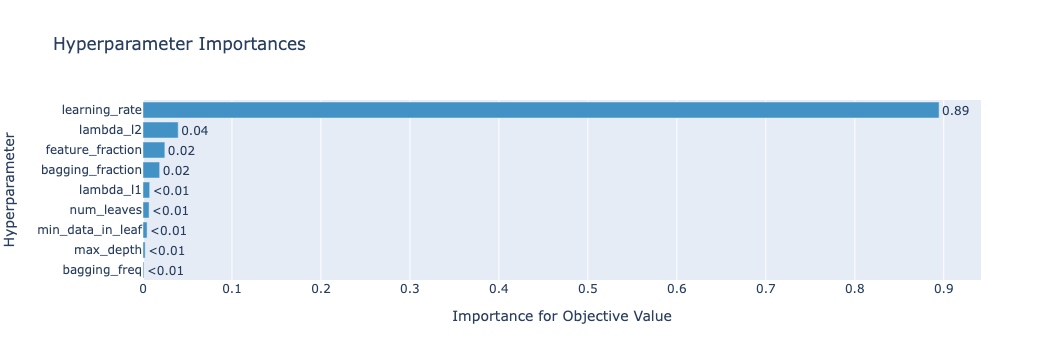

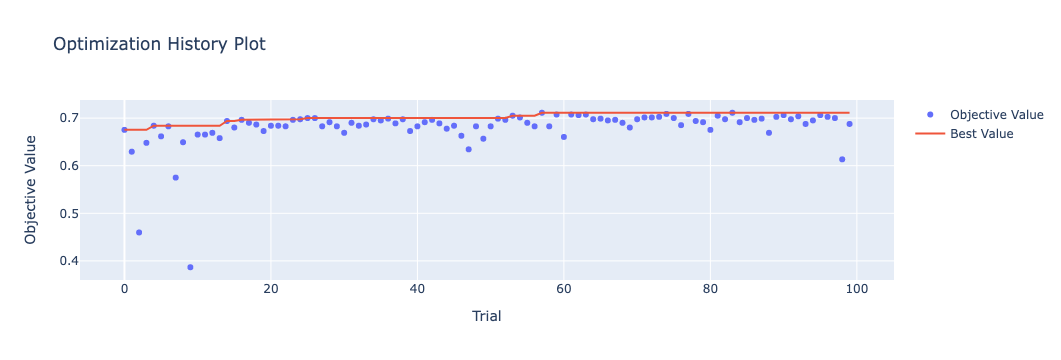

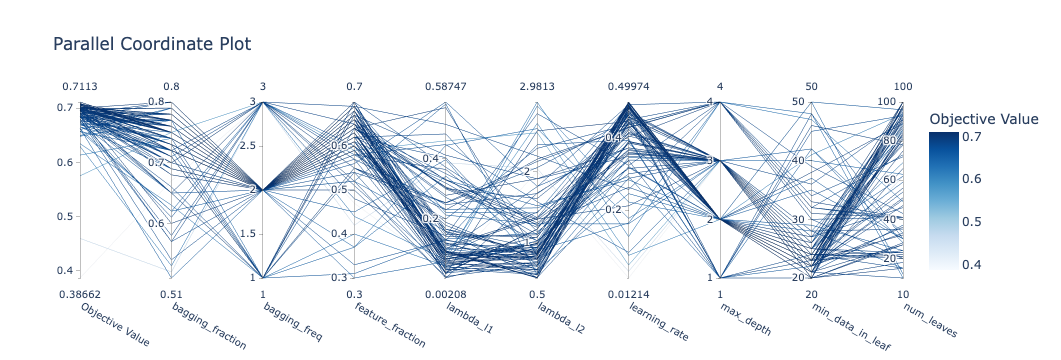

In [12]:
plot_param_importances(gbm_study)
plot_optimization_history(gbm_study)
plot_parallel_coordinate(gbm_study)

if clargs["SAVE"]["PLOT"]:
  plot_param_importances(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-param-imp.png", scale=4)
  plot_optimization_history(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-history.png", scale=4)
  plot_parallel_coordinate(gbm_study).write_image(f"{clargs['SAVE']['PFX']}-GBM-optuna-parallel.png", scale=4)

#### Model Performance

<Figure size 640x480 with 0 Axes>

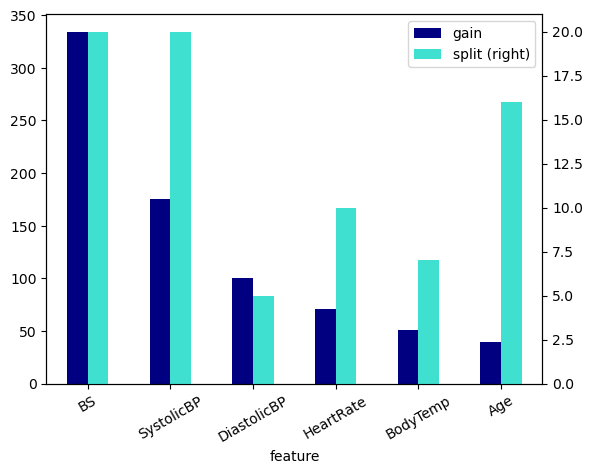

In [13]:
fig = plt.figure()
df = pd.DataFrame({"feature":Xs["train"].columns, "gain":gbm_model.feature_importance("gain"), 
    "split":gbm_model.feature_importance("split")}).sort_values("gain", ascending=False).reset_index(drop=True)
_ = df.plot.bar(x="feature", y=["gain","split"], color=["navy","turquoise"], secondary_y="split", rot=30)

if clargs["SAVE"]["PLOT"]:
  _ = plt.savefig(f"{clargs['SAVE']['PFX']}-GBM-feaimp.png", dpi=300, bbox_inches="tight")

auc (ovr): 90.35%   auc (ovo): 90.62%
ap (ovr): 83.21%   ap (ovo): 90.40%


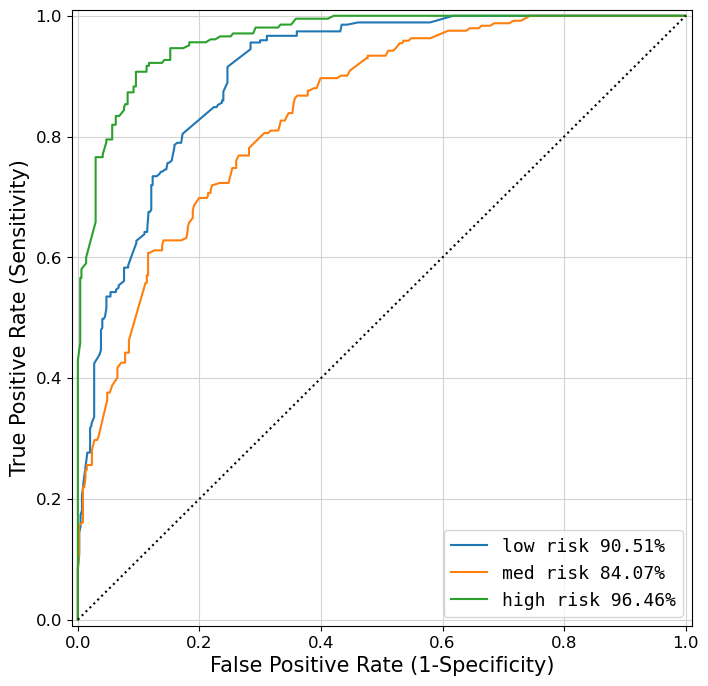

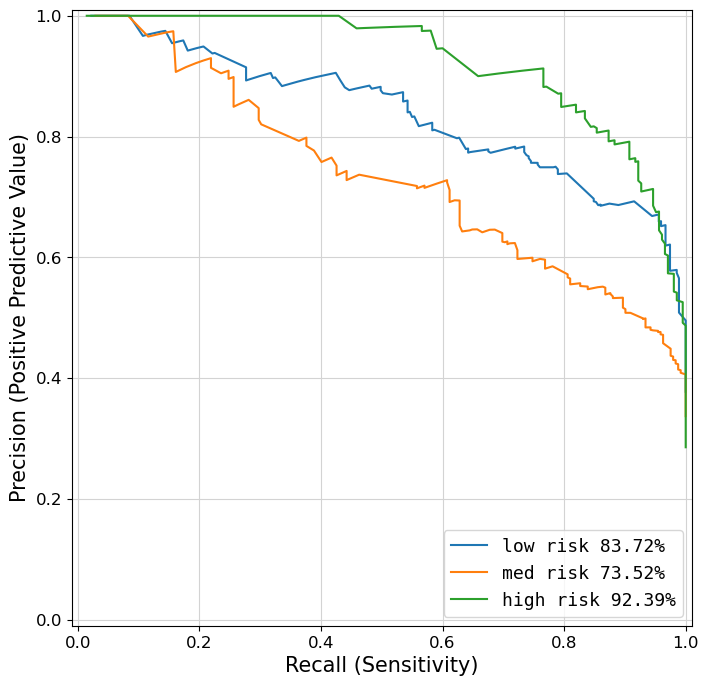

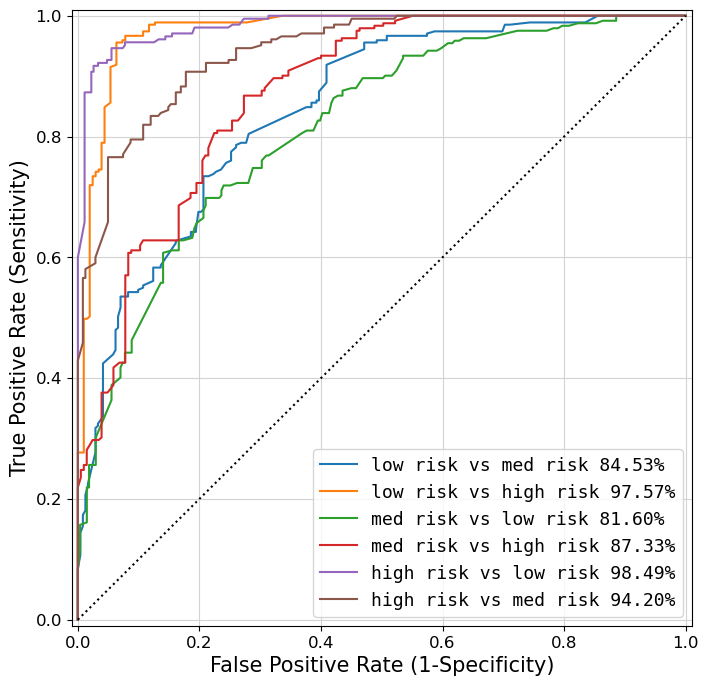

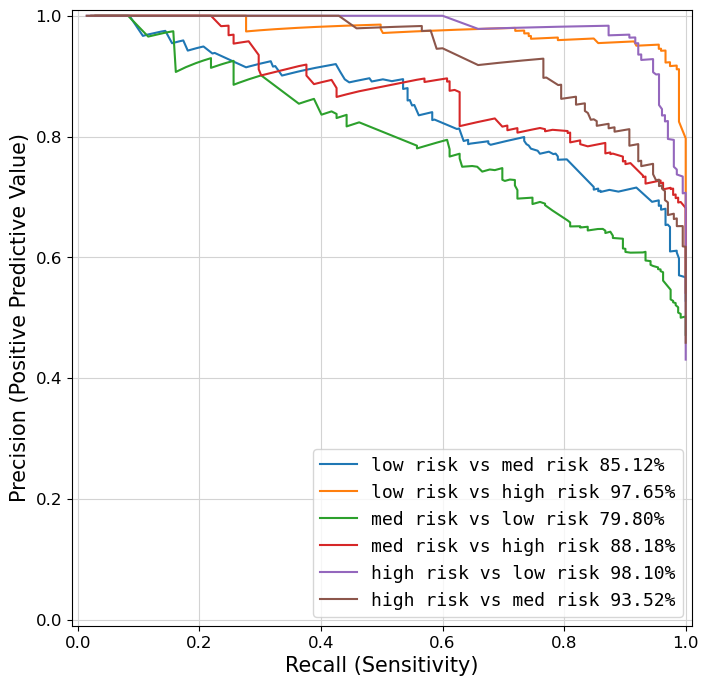

In [14]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def ovr(label, pred, names):
  bcm = BinaryLabelMetrics(); auc = list()
  for n,name in enumerate(names):
    df = pd.DataFrame({"label":np.where(label==n,1,0),"score":pred[:,n]})
    bcm.addModel(name, df)
    auc.append(roc_auc_score(df["label"],df["score"]))
  return bcm

def ovo(label, pred, names):
  bcm = BinaryLabelMetrics(); auc = list()
  for n1,name1 in enumerate(names):
    for n2,name2 in enumerate(names):
      if n1==n2: continue
      
      inds = np.where(np.isin(label,[n1,n2]))[0]
      df = pd.DataFrame({"label":np.where(label[inds]==n1,1,0),"score":pred[inds,n1]})
      bcm.addModel(f"{name1} vs {name2}", df)
      auc.append(roc_auc_score(df["label"],df["score"]))
  return bcm
        

names = ["low risk","med risk","high risk"]; k = "train"
ehr_gbm_ovr = ovr(ys[k], gbm_model.predict(Xs[k]), names)
ehr_gbm_ovo = ovo(ys[k], gbm_model.predict(Xs[k]), names)

print(f"auc (ovr): {np.mean(ehr_gbm_ovr._auc):.2%}   auc (ovo): {np.mean(ehr_gbm_ovo._auc):.2%}")
print(f"ap (ovr): {np.mean(ehr_gbm_ovr._prrec):.2%}   ap (ovo): {np.mean(ehr_gbm_ovo._prrec):.2%}")
ehr_gbm_ovr.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False})
ehr_gbm_ovo.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False})

if clargs["SAVE"]["PLOT"]:
  ehr_gbm_ovr.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False, "save":True, "prefix":f"{clargs['SAVE']['PFX']}-GBM-ovr-"})
  ehr_gbm_ovo.plotROC(chart_types=[1,2], params={"legloc":4, "addsz":False, "save":True, "prefix":f"{clargs['SAVE']['PFX']}-GBM-ovo-"})

[train]
auc_ovo 90.62%    auc_ovr 90.35%
              precision    recall  f1-score   support

         low       0.75      0.82      0.78       271
         med       0.66      0.64      0.65       242
        high       0.87      0.80      0.83       205

    accuracy                           0.75       718
   macro avg       0.76      0.75      0.75       718
weighted avg       0.75      0.75      0.75       718



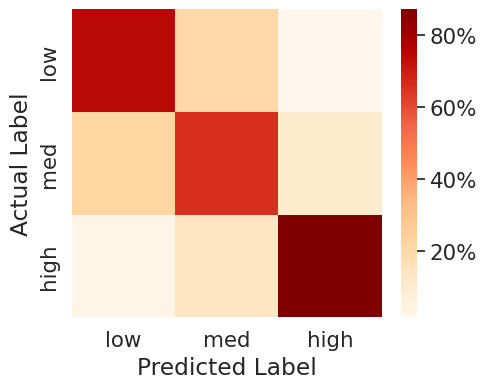

[valid]
auc_ovo 88.23%    auc_ovr 88.00%
              precision    recall  f1-score   support

         low       0.78      0.76      0.77        41
         med       0.52      0.58      0.55        24
        high       0.86      0.79      0.83        24

    accuracy                           0.72        89
   macro avg       0.72      0.71      0.71        89
weighted avg       0.73      0.72      0.72        89



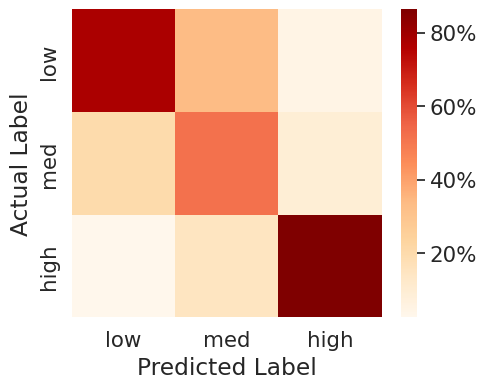

[test]
auc_ovo 86.02%    auc_ovr 85.61%
              precision    recall  f1-score   support

         low       0.72      0.82      0.77        94
         med       0.58      0.54      0.56        70
        high       0.80      0.65      0.72        43

    accuracy                           0.69       207
   macro avg       0.70      0.67      0.68       207
weighted avg       0.69      0.69      0.69       207



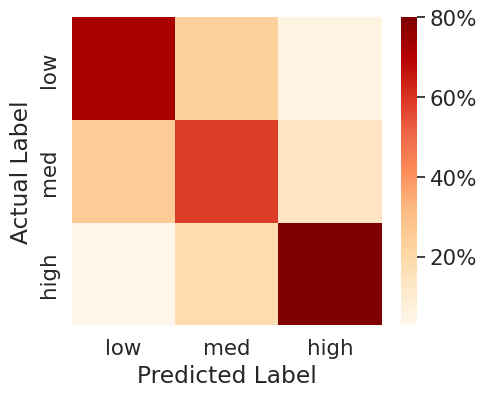

In [15]:
names = ["low","med","high"]

for k in clargs["SPLIT"]["LABELS"]:
  print(f"[{k}]")
  pred = gbm_model.predict(Xs[k]) 
  print(f"auc_ovo {roc_auc_score(ys[k],pred,multi_class='ovo'):.2%}    auc_ovr {roc_auc_score(ys[k],pred,multi_class='ovr'):.2%}")
  print(classification_report(ys[k], pred.argmax(axis=1), target_names=names))
  
  fmt = lambda x,pos: '{:.0%}'.format(x)
  cmat_df = pd.DataFrame(confusion_matrix(ys[k], pred.argmax(axis=1)), index=names, columns=names)
  cmat_df = cmat_df/cmat_df.sum()
  _ = plt.figure(figsize=(5,4))
  _ = sns.set(font_scale=1.4) # for label size
  _ = sns.heatmap(cmat_df, annot=False, annot_kws={"size":16}, cmap="OrRd", fmt=".0%",
                     cbar_kws={"format":FuncFormatter(fmt)}) # font size
  _ = plt.xlabel("Predicted Label"); _ = plt.ylabel("Actual Label")
    
  if clargs["SAVE"]["PLOT"]:
    _ = plt.savefig(f"{clargs['SAVE']['PFX']}-GBM-{k}.png", bbox_inches="tight", dpi=300)
  _ = plt.show()

del cmat_df, fmt, k, names, pred

In [16]:
args = dict(
  show_info=["internal_count","data_percentage"][1],
  orientation=["vertical","horizontal"][0],
  format="pdf",
)

#all trees in one pdf file
merger = PdfMerger(strict=True)
for tree in range(gbm_model.best_iteration):
  name = f"LAB-GBM-tree{tree}"
  graph = lgb.create_tree_digraph(gbm_model, **args, tree_index=tree, name=name)
  _ = graph.render()
  merger.append(open(f"{name}.gv.pdf","rb"), import_outline=False)
  os.remove(f"{name}.gv.pdf"); os.remove(f"{name}.gv")

merger.write(f"{clargs['SAVE']['PFX']}-GBM-trees.pdf")
merger.close()

#first two trees as pngs
args["format"] = "png"
for tree in [0,1]:
  name = f"{clargs['SAVE']['PFX']}-GBM-tree{tree}"
  graph = lgb.create_tree_digraph(gbm_model, **args, tree_index=tree, name=name)
  _ = graph.render()
  os.remove(f"{name}.gv")

del args, merger, name, tree

In [17]:
#del gbm_model, gbm_study

In [56]:
#BS  <7.8 normal, 7.8-11 pre-DM, >11 DM
#HR   60-100 normal

exam = pd.DataFrame(
    [
      [25,100,80,6.0,99,70],
      [25,100,80,12,99,70],
      [25,140,90,6.0,99,70],
      [25,140,90,12,99,70],
    ], columns=["Age","SystolicBP","DiastolicBP","BS","BodyTemp","HeartRate"]
  )
exam
pd.DataFrame(gbm_model.predict(exam), columns=["low","medium","high"]).multiply(100.)

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
0   25         100           80   6.0        99         70
1   25         100           80  12.0        99         70
2   25         140           90   6.0        99         70
3   25         140           90  12.0        99         70

low     medium       high
0  55.892148  37.910639   6.197214
1  10.889448  29.913813  59.196739
2  10.567278  16.571907  72.860814
3   0.600685   2.785179  96.614137